# Boston Marathon Data - 2014

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

#pd.set_option("display.max_columns", 500)

## Load and prep data for analysis

In [2]:
url = "https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv"
df = pd.read_csv(url)
ordered_cols = ["name", "gender", "age", "country", "ctz", "state", "city", "division", "genderdiv",
               "bib", "pace", "5k", "10k", "20k", "half", "25k", "30k", "35k", "40k", "official", "overall"]
df = df[ordered_cols]
print("Rows: {}\nColumns: {}".format(df.shape[0], df.shape[1]))
df.head()

Rows: 31984
Columns: 21


,name,gender,age,country,ctz,state,city,division,genderdiv,bib,...,5k,10k,20k,half,25k,30k,35k,40k,official,overall
0,"Yamamoto, Hiroyuki",M,47,JPN,NaN,NaN,Fukuoka,8,8,W1,...,8.02,17.37,37.65,39.72,47.67,59.18,71.40,80.43,85.25,8
1,"Jeptoo, Rita",F,33,KEN,NaN,NaN,Eldoret,1,1,F1,...,16.22,32.58,65.83,69.47,82.43,99.33,116.37,132.10,138.95,21
2,"Van Dyk, Ernst F.",M,41,RSA,NaN,NaN,Paarl,1,1,W2,...,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,1
3,"Dibaba, Mare",F,24,ETH,NaN,NaN,Shoa,3,3,F2,...,16.20,32.57,65.83,69.47,82.43,99.33,116.37,132.95,140.58,27
4,"Hokinoue, Kota",M,40,JPN,NaN,NaN,Nogata Fukuoka,2,2,W3,...,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,2


In [3]:
cat_cols = ["name", "gender", "country", "ctz", "state", "city", "division", "genderdiv", "bib"]
quant_cols_int = ordered_cols = ["age", "overall"]
quant_cols_float = ["pace", "5k", "10k", "20k", "half", "25k", "30k", "35k", "40k", "official"]

for col in cat_cols:
    df[col] = df[col].astype("category")
for col in quant_cols_int:
    df[col] = df[col].astype("int64")
for col in quant_cols_float:
    df[col] = pd.to_numeric(df[col], errors="coerce")

In [4]:
df.isnull().sum()

name             0
gender           0
age              0
country          0
ctz          30740
state         2576
city             1
division         0
genderdiv        0
bib              0
pace             0
5k              52
10k             50
20k             51
half            72
25k            216
30k             40
35k             34
40k             39
official         0
overall          0
dtype: int64

In [5]:
consider_cols = ["name", "gender", "age", "country", "division", "genderdiv",
                 "bib", "pace", "5k", "10k", "20k", "half", "25k", "30k", "35k", "40k", "official", "overall"]
df.dropna(subset=consider_cols, inplace=True)
df.isnull().sum()

name             0
gender           0
age              0
country          0
ctz          30411
state         2546
city             1
division         0
genderdiv        0
bib              0
pace             0
5k               0
10k              0
20k              0
half             0
25k              0
30k              0
35k              0
40k              0
official         0
overall          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31649 entries, 0 to 31983
Data columns (total 21 columns):
name         31649 non-null category
gender       31649 non-null category
age          31649 non-null int64
country      31649 non-null category
ctz          1238 non-null category
state        29103 non-null category
city         31648 non-null category
division     31649 non-null category
genderdiv    31649 non-null category
bib          31649 non-null category
pace         31649 non-null float64
5k           31649 non-null float64
10k          31649 non-null float64
20k          31649 non-null float64
half         31649 non-null float64
25k          31649 non-null float64
30k          31649 non-null float64
35k          31649 non-null float64
40k          31649 non-null float64
official     31649 non-null float64
overall      31649 non-null int64
dtypes: category(9), float64(10), int64(2)
memory usage: 7.9 MB


In [7]:
print("Rows: {}\nColumns: {}".format(df.shape[0], df.shape[1]))

Rows: 31649
Columns: 21


In [8]:
# Helper function to find unique column values
def unique_col_values(df):
    max_name_len = np.max([len(col_name) for col_name in df.columns]) + 2
    format_str = "{:<" + str(max_name_len) + "}{:<8}{:<15}"

    print(format_str.format("Name", "Unique", "DType"))
    print()
    for col in df:
        print(format_str.format(df[col].name, len(df[col].unique()), str(df[col].dtype)))

unique_col_values(df)

Name       Unique  DType          

name       31581   category       
gender     2       category       
age        64      int64          
country    78      category       
ctz        85      category       
state      69      category       
city       5906    category       
division   6921    category       
genderdiv  17490   category       
bib        31649   category       
pace       702     float64        
5k         1433    float64        
10k        2659    float64        
20k        5228    float64        
half       5489    float64        
25k        6556    float64        
30k        7926    float64        
35k        9342    float64        
40k        10391   float64        
official   10848   float64        
overall    31596   int64          


In [9]:
quant_cols = ["age", "pace", "5k", "10k", "20k", "half", "25k", "30k", "35k", "40k", "official"]
X = df[quant_cols]

In [10]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

## Hierarchical clustering

In [11]:
#from scipy.cluster.hierarchy import linkage
#row_clusters = linkage(pdist(X_sc, metric="euclidean"), method="complete")

This crashed my computer three times in a row. And I mean crashed. Not just the kernel. Not even just the browser. The entire computer completely freezes and needs to be shut down when I try running this.

In [12]:
#from scipy.cluster.hierarchy import dendrogram
#row_dendr = dendrogram(row_clusters)
#plt.tight_layout()
#plt.ylabel("Euclidean distance")
#plt.show()

## K Means

### Elbow method

In [13]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i)
    km.fit(X_sc)
    distortions.append(km.inertia_)

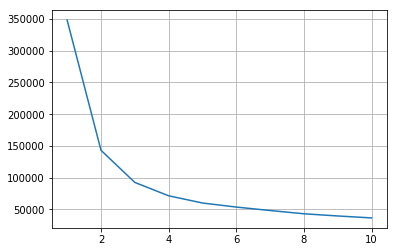

In [14]:
plt.plot(range(1, 11), distortions)
plt.grid()
plt.show()

Looks like distortion settles down at 4 clusters.

### Silhouette coefficients

In [15]:
for i in range(2, 6):
    km = KMeans(n_clusters=i)
    y_pred = km.fit_predict(X_sc)
    silhouette = silhouette_score(X_sc, y_pred, metric="euclidean")
    print("N: {}, Silhoutte score: {}".format(i, silhouette))

N: 2, Silhoutte score: 0.5099409399468674
N: 3, Silhoutte score: 0.40239889952544106
N: 4, Silhoutte score: 0.35295798625780744
N: 5, Silhoutte score: 0.32008019700706575


This would seem to imply that 2 clusters is optimal. (?)

In [16]:
cluster_labels = np.unique(y_pred)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_sc, y_pred, metric="euclidean")

In [17]:
# Run with two clusters and graph
km = KMeans(n_clusters=2)
y_pred = km.fit_predict(X_sc)

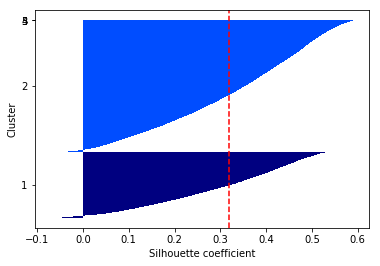

In [18]:
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor="none", color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.0)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.show()

In [19]:
# Run with four clusters and graph
km = KMeans(n_clusters=4)
y_pred = km.fit_predict(X_sc)

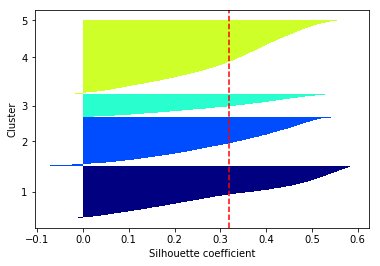

In [20]:
y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor="none", color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.0)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.show()

I honestly don't see how to parase between 2 clusters and 4 clusters given the above.

## Mean-shift

In [21]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X_sc, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
y_pred = ms.fit_predict(X_sc)

In [22]:
labels = ms.labels_
n_clusters = len(np.unique(labels))
print("Number of estimated clusters: {}".format(n_clusters))
silhouette = silhouette_score(X_sc, y_pred, metric="euclidean")
print("N: {}, Silhoutte score: {}".format(n_clusters, silhouette))

Number of estimated clusters: 4
N: 4, Silhoutte score: 0.510536839308842


At four clusters, mean-shift might be slightly outperforming KMeans? In any event, it took almost an hour to run.

## Spectral Clustering

In [25]:
from sklearn.cluster import SpectralClustering
for i in range(2, 5):
    sc = SpectralClustering(n_clusters=i)
    y_pred = sc.fit_predict(X_sc)
    print("Done")
    silhouette = silhouette_score(X_sc, y_pred, metric="euclidean")
    print("N: {}, Silhoutte score: {}".format(i, silhouette))

Done
N: 2, Silhoutte score: 0.2565689884522057
Done
N: 3, Silhoutte score: 0.08717808790854063
Done
N: 4, Silhoutte score: 0.09496458645854033


Not very impressive results, and took hours to run.

## Affinity Propagation

In [26]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(max_iter=200, convergence_iter=15).fit(X_sc)
print('Done')
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_
print('Estimated number of clusters: {}'.format(n_clusters_))

KeyboardInterrupt: 

After over six+ hours of running, I give up.

I would say that KMeans wins if only for the reason that it runs in a timeframe amenable to a human lifespan.

## Best model: KMeans

Open question: 2 or 4 clusters?

In [27]:
# Assume four clusters in the interest of moving forward
km = KMeans(n_clusters=4)
y_pred = km.fit_predict(X_sc)

In [28]:
df["target"] = y_pred

In [29]:
df.groupby("target").describe().T

target                     0             1             2             3
10k      count   8392.000000   3712.000000  11861.000000   7684.000000
         mean      41.973676     67.364235     49.609784     57.689573
         std        3.343501      5.264788      2.643146      3.412237
         min       16.620000     41.780000     39.950000     42.580000
         25%       40.480000     63.920000     47.680000     55.320000
         50%       42.420000     66.710000     49.380000     57.470000
         75%       44.170000     70.130000     51.500000     60.080000
         max       49.470000    112.380000     57.850000     69.420000
20k      count   8392.000000   3712.000000  11861.000000   7684.000000
         mean      84.501693    142.015835    100.407402    117.918261
         std        6.559934     11.240746      5.124206      6.600240
         min       36.100000    103.430000     82.730000     85.950000
         25%       81.350000    133.965000     96.470000    112.670000
         50%       85.290000    139.710000     99.970000    117.120000
         75%       89.050000    148.150000    104.370000    122.955000
         max       97.750000    224.350000    117.970000    146.570000
25k      count   8392.000000   3712.000000  11861.000000   7684.000000
         mean     106.176040    183.591352    126.653900    150.045325
         std        8.294352     14.850734      6.503287      8.528022
         min       45.800000    141.230000    105.470000    108.130000
         25%      102.080000    172.257500    121.480000    142.900000
         50%      107.100000    180.760000    126.150000    149.040000
         75%      112.030000    192.370000    131.830000    156.650000
         max      123.620000    289.020000    149.230000    179.880000
30k      count   8392.000000   3712.000000  11861.000000   7684.000000
         mean     128.967378    228.650835    154.581667    185.134028
         std       10.234097     18.777660      8.194232     11.130930
         min       56.450000    185.620000    128.600000    131.970000
         25%      123.750000    213.860000    147.970000    175.680000
         50%      130.170000    224.910000    154.050000    184.050000
...                      ...           ...           ...           ...
half     std        6.926424     11.871709      5.394082      6.949228
         min       38.030000    110.320000     87.380000     90.730000
         25%       85.850000    141.630000    101.820000    118.950000
         50%       89.980000    147.780000    105.520000    123.700000
         75%       93.950000    156.640000    110.180000    129.785000
         max      103.280000    236.670000    123.520000    152.500000
official count   8392.000000   3712.000000  11861.000000   7684.000000
         mean     188.310498    339.290792    227.176548    276.322333
         std       16.915553     27.794414     14.686313     19.755675
         min       80.600000    258.220000    192.900000    224.000000
         25%      178.620000    318.765000    215.930000    260.970000
         50%      190.050000    335.310000    226.250000    274.630000
         75%      199.520000    355.590000    237.130000    289.730000
         max      260.430000    538.880000    303.120000    404.380000
overall  count   8392.000000   3712.000000  11861.000000   7684.000000
         mean    4459.488441  29712.047683  14236.198718  24018.514446
         std     3033.770582   1326.850535   3945.137865   2658.597821
         min        1.000000  21536.000000   4780.000000  13615.000000
         25%     2045.750000  28765.500000  11113.000000  22026.750000
         50%     4149.500000  29835.500000  14256.000000  24110.500000
         75%     6340.250000  30802.250000  17306.000000  26094.250000
         max    21934.000000  31931.000000  27508.000000  31754.000000
pace     count   8392.000000   3712.000000  11861.000000   7684.000000
         mean       7.190466     12.948895      8.672934     10.547432
         std        0.64